<a href="https://colab.research.google.com/github/yebiny/SkillTreePython-DeepLearning/blob/main/03.NLP-with-tensorflow2.0/%ED%95%B4%EC%84%A4/ch03_04_%EC%88%9C%ED%99%98%EC%8B%A0%EA%B2%BD%EB%A7%9D_Bidirectional_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ch03.04_순환신경망 - Bidirectional-LSTM
---

* 날짜:
* 이름:


## 학습내용
    - 순환 신경망에 대해 이해한다.
    - BiLSTM
    - 로이터 뉴스기사 카테고리 분류
    - 스팀 리뷰 걈성 분류

```
! git clone https://github.com/yebiny/SkillTreePython-DeepLearning
```

In [1]:
! git clone https://github.com/yebiny/SkillTreePython-DeepLearning

Cloning into 'SkillTreePython-DeepLearning'...
remote: Enumerating objects: 735, done.
remote: Counting objects: 100% (308/308), done.
remote: Compressing objects: 100% (152/152), done.
remote: Total 735 (delta 187), reused 255 (delta 155), pack-reused 427
Receiving objects: 100% (735/735), 38.42 MiB | 30.26 MiB/s, done.
Resolving deltas: 100% (380/380), done.


```
import sys
sys.path.append('/content/SkillTreePython-DeepLearning/scripts')
from import_lib import *
from plot_result import *
```

In [2]:
import sys
sys.path.append('/content/SkillTreePython-DeepLearning/scripts')
from import_lib import *
from plot_result import *

## 로이터 뉴스 기사 분류
---

### | 데이터 전처리 

#### **데이터 불러오기**

In [4]:
MAX_FEATURES = 1000 # 데이터에 1000(-1)개 단어만 포함하기
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.reuters.load_data(num_words=MAX_FEATURES)
print('훈련 데이터: ', x_train.shape, y_train.shape)
print('테스트 데이터: ', x_test.shape, y_test.shape)

2121728/2110848 [==============================] - 0s 0us/step
훈련 데이터:  (8982,) (8982,)
테스트 데이터:  (2246,) (2246,)


#### **데이터 확인**

In [8]:
print('첫번째 기사:', x_train[0]) # 토큰화, 단어 인덱싱이 된 상태
print('첫번째 기사의 카테고리:',  y_train[0])
print('카테고리 개수: ', np.max(y_train)+1) # 클래스가  0~45

첫번째 기사: [1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 2, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 2, 2, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 2, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]
첫번째 기사의 카테고리: 3
카테고리 개수:  46


In [ ]:
word2index = tf.keras.datasets.reuters.get_word_index()

뉴스 기사의 평균길이 :  145.5398574927633


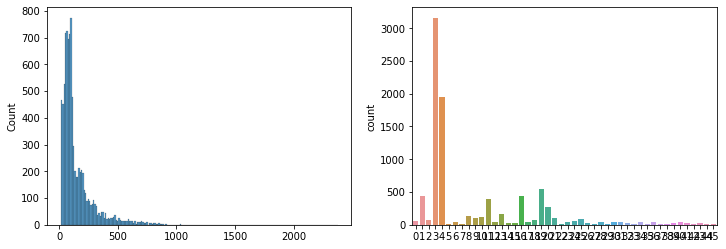

In [13]:
# 뉴스 기사의 평균 길이
plt.figure(figsize=(12,4))
len_sample = [len(x) for x in x_train]
plt.subplot(121);sns.histplot(x=len_sample)
plt.subplot(122);sns.countplot(x=y_train)
print('뉴스 기사의 평균길이 : ', np.mean(len_sample))

In [14]:
# 데이터 전처리: 패딩
MAX_LEN = 128
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=MAX_LEN)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=MAX_LEN)
print('훈련 데이터: ', x_train.shape, y_train.shape)
print('테스트 데이터: ', x_test.shape, y_test.shape)

훈련 데이터:  (8982, 128) (8982,)
테스트 데이터:  (2246, 128) (2246,)


### | 임베딩 매트릭스 제작

```
! gdown https://drive.google.com/u/0/uc?id=1ams5_zp8NrfmbxSzTDCglRpAvjFGi5JY&export=download
! unzip  /content/glove.6B.zip
```


#### **단어-임베딩 딕셔너리**

```
embeddings_index = {}
f = open('glove.6B.100d.txt', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
```

#### **인덱싱-단어 딕셔너리**

In [ ]:
word2index = tf.keras.datasets.reuters.get_word_index()
#print(word2index)
index2word = {}
for word, index in word2index.items():
  #print(word, index)
  index2word[index+3]=word
print(index2word)

In [ ]:
for x in x_train[0]:
  if index2word.get(x)is not None:
    print(index2word[x] ) # 1000개 단어 외에는 생략되기 때문에 

#### **매트릭스 제작**

### | 모델학습 1

이때까지 배운 레이어를 사용하여 모델을 구축하세요.

```
Embedding()
RNN()
LSTM()
GRU()
GlobalAveragePooling1D()
Dense()
```

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128)]             0         
                                                                 
 embedding_3 (Embedding)     (None, 128, 100)          100000    
                                                                 
 gru_3 (GRU)                 (None, 64)                31872     
                                                                 
 dense_3 (Dense)             (None, 46)                2990      
                                                                 
Total params: 134,862
Trainable params: 134,862
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
71/71 [==============================] - 3s 15ms/step - loss: 2.7747 - acc: 0.3399 - val_loss: 2.2005 - val_acc: 0.3620
Epoch 2/20
71/71 [==============================] - 1s

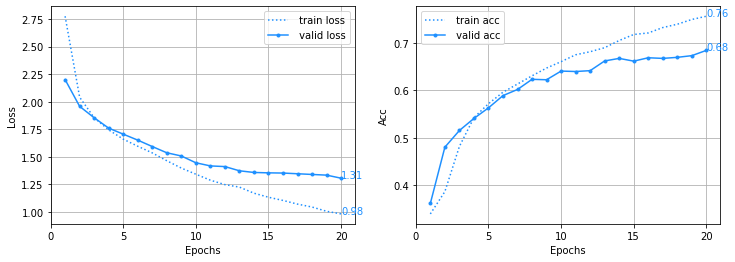

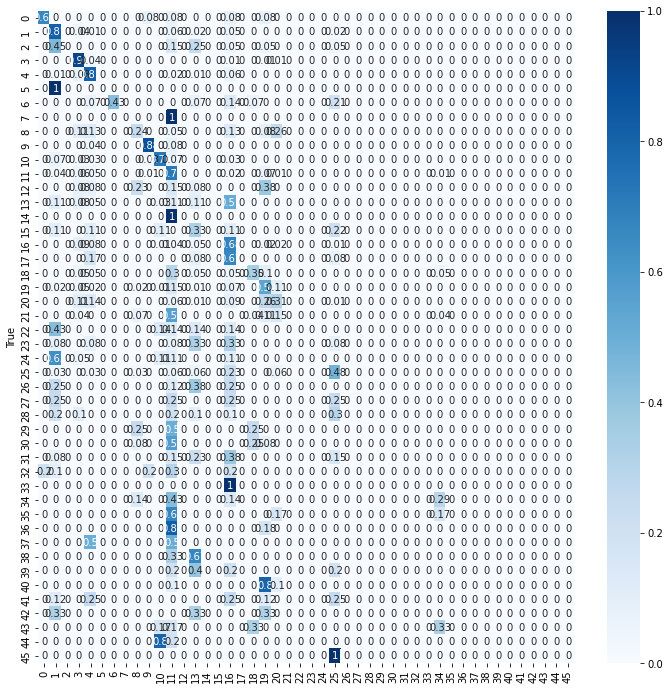

In [31]:
# 레이어를 조합해서 72%이상~

EMB_DIMS=100
x = layers.Input(shape=MAX_LEN)
y = layers.Embedding(MAX_FEATURES, EMB_DIMS)(x)
y = layers.GRU(64)(y)
y = layers.Dense(46, activation='softmax')(y)
model = models.Model(x,y)

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])
model.summary()
history = model.fit(x_train, y_train,
                   batch_size=128,
                   epochs=20,
                   validation_data=(x_test, y_test))

plot_lcurve([history], [''], ['dodgerblue'], x_itv=5)
draw_cm(model, x_test, y_test) # 스크립트-혼돈행렬 플롯

### | 모델학습 2

![](https://www.researchgate.net/profile/Arvind-Mohan-3/publication/324769532/figure/fig2/AS:619510805561344@1524714294669/LSTM-and-BiLSTM-Architectures.png)

## 스팀 리뷰 감성 분류
---

https://wikidocs.net/94748

```
# Colab에 Mecab 설치
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab190912.sh
```